# Clustering using mean shift
This is an example of using clustering data analysis, the template is the FastAI course of 2022. The youtube lesson is Lesson 12 (https://www.youtube.com/watch?v=_xIzPbCgutY&t=1995s), the github repo is at https://github.com/fastai/course22p2/blob/master/nbs/02_meanshift.ipynb

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

# Creating the randomised data

Here we are creating random data using Pytorch multivariate_normal and plotting it

In [3]:
n_clusters = 6 
n_samples = 250 

In [4]:
#picking 6 random points, for each of them there are 250 data points
centroids = torch.rand(n_clusters, 2)*70-35

In [5]:
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [6]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [7]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [8]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [9]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

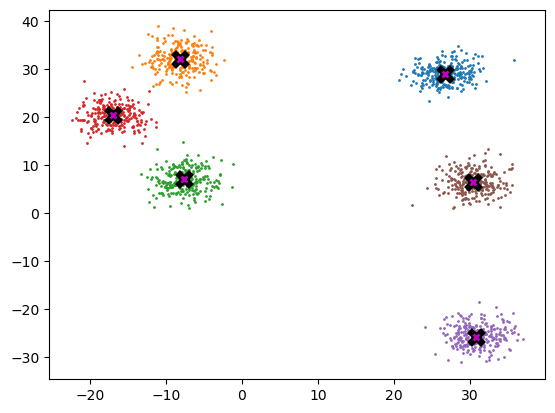

In [10]:
plot_data(centroids, data, n_samples)

In [11]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [12]:
def plot_func(f):
    x = torch.linspace(0, 10, 100)
    plt.plot(x, f(x))

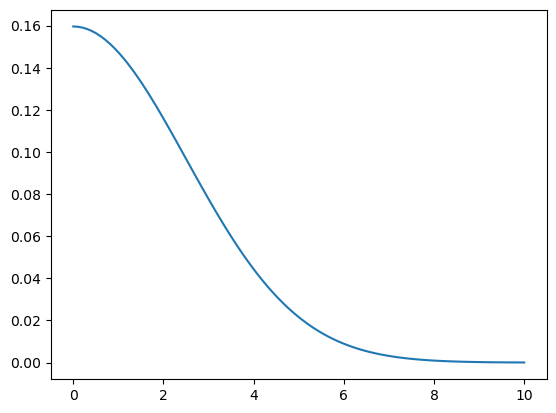

In [13]:
plot_func(partial(gaussian, bw=2.5))

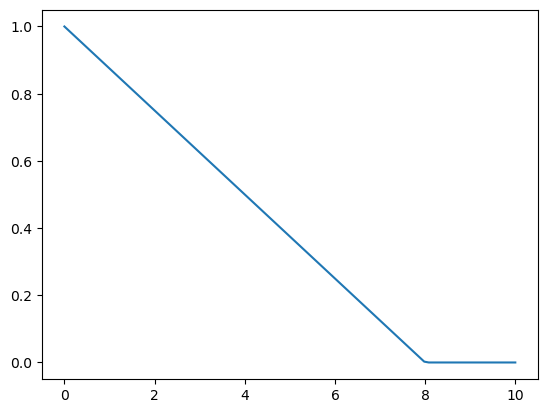

In [14]:
# Note that this looks similar to a diagonal function which can be defined in the following manner:

def tri(d, i): return (-d+i).clamp_min(0)/i
plot_func(partial(tri, i=8))


Collecting our data so we can do our analysis on it

In [15]:
X = data.clone()
x = data[0]
x

tensor([26.204, 26.349])

In [16]:
# Calculate the distances between point x and all the points in the tensor X

dist = ((X-x)**2).sum(1).sqrt()
dist

tensor([ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617])

In [17]:
#Doing the same, but using Einstein summation, there is probably a better way
dist_ein = torch.sqrt(torch.einsum('ij,ij->i', (x-X)**2, torch.ones(X.shape)))
dist_ein

tensor([ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617])

In [18]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [19]:
weight.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [20]:
weight[:,None].shape

torch.Size([1500, 1])

In [21]:
#This is how we get the 'weight' tensor in the correct shape in order to multiply it with the X-tensor
weight[:,None]


tensor([[    0.160],
        [    0.047],
        [    0.025],
        ...,
        [    0.000],
        [    0.000],
        [    0.000]])

In [22]:
weight[:,None]*X

tensor([[    4.182,     4.205],
        [    1.215,     1.429],
        [    0.749,     0.706],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [23]:
def one_update(X):
    for i, x in enumerate(X):
        dist = ((X-x)**2).sum(1).sqrt()
        weight = gaussian(dist, 2.5)
        X[i] = (weight[:,None]*X).sum(0) / weight.sum()


In [24]:
# The Mean shift updat is only iterating the above function 5 times


def meanshift(data):
        X = data.clone()
        for it in range(5): one_update(X)
        return X

In [25]:
%time X=meanshift(data)


CPU times: user 1.46 s, sys: 0 ns, total: 1.46 s
Wall time: 740 ms


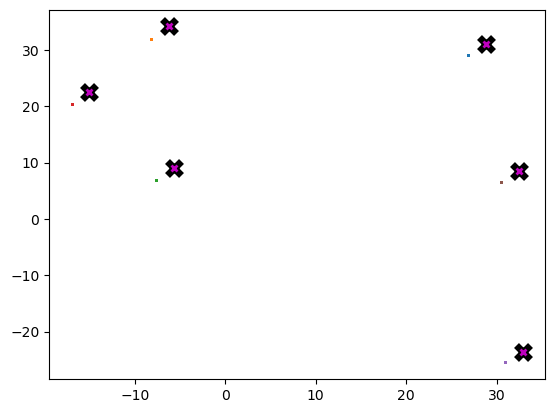

In [26]:
plot_data(centroids+2, X, n_samples)


# Making an animation to show the convergence of the points


In [27]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [28]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [29]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())
     

# Using the GPU to accelerate 

In [30]:
bs = 5
X = data.clone()
x = X[:5]
x.shape, X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [31]:
# We will need to add unit axis to the matrices so they can be multiplied together, doing the this in the following function

X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [32]:
def dist_b(a,b): return (((a[None] - b[:,None])**2).sum(2)).sqrt()

In [33]:
??gaussian

Signature: gaussian(d, bw)
Docstring: <no docstring>
Source:    def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))
File:      /tmp/ipykernel_2161/1178221795.py
Type:      function

In [34]:
weight = gaussian(dist_b(X, x), 2)
weight.shape

torch.Size([5, 1500])

In [35]:
# One way to update the new weights using the unit axes
num = (weight[...,None]*X[None]).sum(1)
num

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [36]:
# Or using Einsum
torch.einsum('ij,jk->ik', weight, X)

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.218],
        [231.302, 234.155]])

In [37]:
# Or using pytorch's matrix multiplication function
weight@X

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.218],
        [231.302, 234.155]])

In [38]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [39]:
num/div

tensor([[26.376, 27.692],
        [26.101, 29.643],
        [28.892, 28.990],
        [26.071, 29.559],
        [29.323, 29.685]])

In [40]:
x = range(0, 10, 3)
x

range(0, 10, 3)

In [41]:
# Using batches to perform the meanshift algorithm

def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs, n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div

In [42]:
#Time it takes to run on CPU

%timeit -n 5 X = meanshift(data)

130 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [43]:
data = data.cuda()
%timeit -n 5 X = meanshift(data, 500)

The slowest run took 185.73 times longer than the fastest. This could mean that an intermediate result is being cached.
93.8 ms ± 195 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [44]:
# Experimenting with different batch sizes
data = data.cuda()
%timeit -n 5 X = meanshift(data, 1000)

4.02 ms ± 984 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [45]:
data = data.cuda()
%timeit -n 5 X = meanshift(data, 1500)

The slowest run took 11.35 times longer than the fastest. This could mean that an intermediate result is being cached.
4.66 ms ± 4.76 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


Homework: implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D

## K Means clustering

K-means clustering
(using ChatGPT for guidance)
K means clustering is a parametric algorithm, so it needs a priori knowledge of the number of clusters in the data. It is also a form of unsupervised learning. It is fast and scalable, but may not work for complex clusters shapes and sizes.

In [46]:
def k_means(data, k, n_iterations=10):
    # Initialize k centroids randomly
    indices = torch.randperm(data.shape[0])[:k]
    centroids = data[indices]
    
    for i in range(n_iterations):
        # Assign each point to the closest centroid
        distances = ((data[:, None] - centroids) ** 2).sum(dim=2)
        assignments = torch.argmin(distances, dim=1)
        
        # Update centroids
        for j in range(k):
            mask = (assignments == j)
            if mask.any():
                centroids[j] = data[mask].mean(dim=0)
    
    return centroids

In [47]:
centroids = k_means(data, 6)
centroids

tensor([[ -7.635,   6.958],
        [ 30.427,   6.500],
        [ 26.780,  29.194],
        [ 30.937, -25.434],
        [-16.998,  20.357],
        [ -8.179,  32.048]], device='cuda:0')

The actual centroids for reference:
    
tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

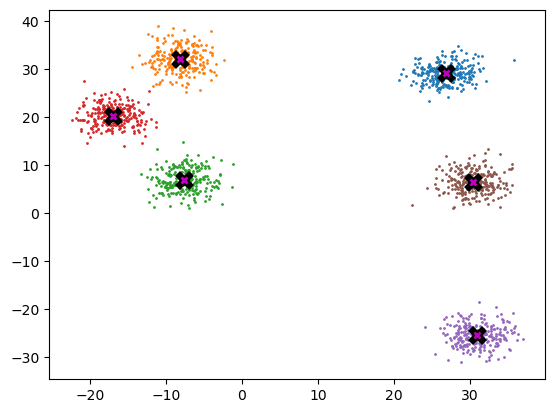

In [48]:
# Move data to CPU and convert to Numpy in order to plot:

# plot_centroids = centroids.cpu().numpy()
# # plot_centroids = plot_centroids.numpy()
# # plot_data = data.cpu().numpy()
# plot_data(centroids, data, n_samples)

plot_data(centroids.cpu().numpy(), data.cpu().numpy(), n_samples)

ChatGPT's suggested code using scikitlearn:

def kmeanshift(data, k=8, bs=500, n_iter=5):
    # Initialize centroids using K-means clustering
    kmeans = KMeans(n_clusters=k).fit(data)
    centroids = kmeans.cluster_centers_

    # Iterate over data using batches
    n = len(data)
    for it in range(n_iter):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs, n))

            # Calculate distances between data points and centroids
            dist = cdist(data[s], centroids)

            # Calculate weights based on distances
            weight = 1 / (1 + dist**2)

            # Shift data points towards nearest centroid
            X = data[s]
            div = weight.sum(axis=1, keepdims=True)
            X = (weight @ centroids) / div

            # Assign data points to nearest centroid
            labels = np.argmax(cdist(X, centroids), axis=1)

            # Update centroids based on new assignments
            for j in range(k):
                centroids[j] = X[labels==j].mean(axis=0)

    return X
    
And without SciKit:

import torch

def k_means(data, k, n_iterations=10):
    # Initialize k centroids randomly
    indices = torch.randperm(data.shape[0])[:k]
    centroids = data[indices]
    
    for i in range(n_iterations):
        # Assign each point to the closest centroid
        distances = ((data[:, None] - centroids) ** 2).sum(dim=2)
        assignments = torch.argmin(distances, dim=1)
        
        # Update centroids
        for j in range(k):
            mask = (assignments == j)
            if mask.any():
                centroids[j] = data[mask].mean(dim=0)
    
    return centroids